In [ ]:
!pip install point-cloud-utils
!pip install scikit-image

In [1]:
import point_cloud_utils as pcu
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity

2023-08-27 13:56:17.234317: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    # Create a 2D rectangular grid for the rays corresponding to image dimensions
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    # Normalize the x-axis coordinates
    transformed_i = (i - W * 0.5) / focal
    # Normalize the y-axis coordinates
    transformed_j = -(j - H * 0.5) / focal
    # z-axis coordinates
    k = -tf.ones_like(i)
    # Create the unit vectors corresponding to ray directions
    dirs = tf.stack([transformed_i, transformed_j, k], -1)
    # Compute Origins and Directions for each ray
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    # rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    rays_o = tf.cast(tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d)), dtype=tf.float32)
    return rays_o, rays_d

Combine SDF and NeRF

In [4]:
def render_rays(network_fn, v, f, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # print('pts', tf.shape(pts))
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])


    # Calculate 3D query points sdf value
    pts_flat = pts_flat.numpy().astype(np.float32)
    v = v.astype(np.float32, order='C').copy()
    v_reshaped = v[:, :3]
    sdfs, face_ids, barycentric_coords = pcu.signed_distance_to_mesh(pts_flat, v_reshaped, f)

    # print('flat', tf.shape(pts_flat))
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors use NeRF
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Use SDF value to calculate opacities
    sigma_a_sdf = tf.nn.sigmoid(-sdfs)
    sigma_a_sdf = tf.reshape(sigma_a_sdf, list(pts.shape[:-1]))

    # Combine SDF opacities and NeRF opacities
    combined_sigma_a = (sigma_a + sigma_a_sdf) / 2

    # Do volume rendering with combine opacities
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-combined_sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map
    # return rgb_map, depth_map, acc_map, consistency, consistency_loss

In [ ]:
Egypt model reconstruction

(100, 200, 200, 3) (100, 4, 4) 1.0


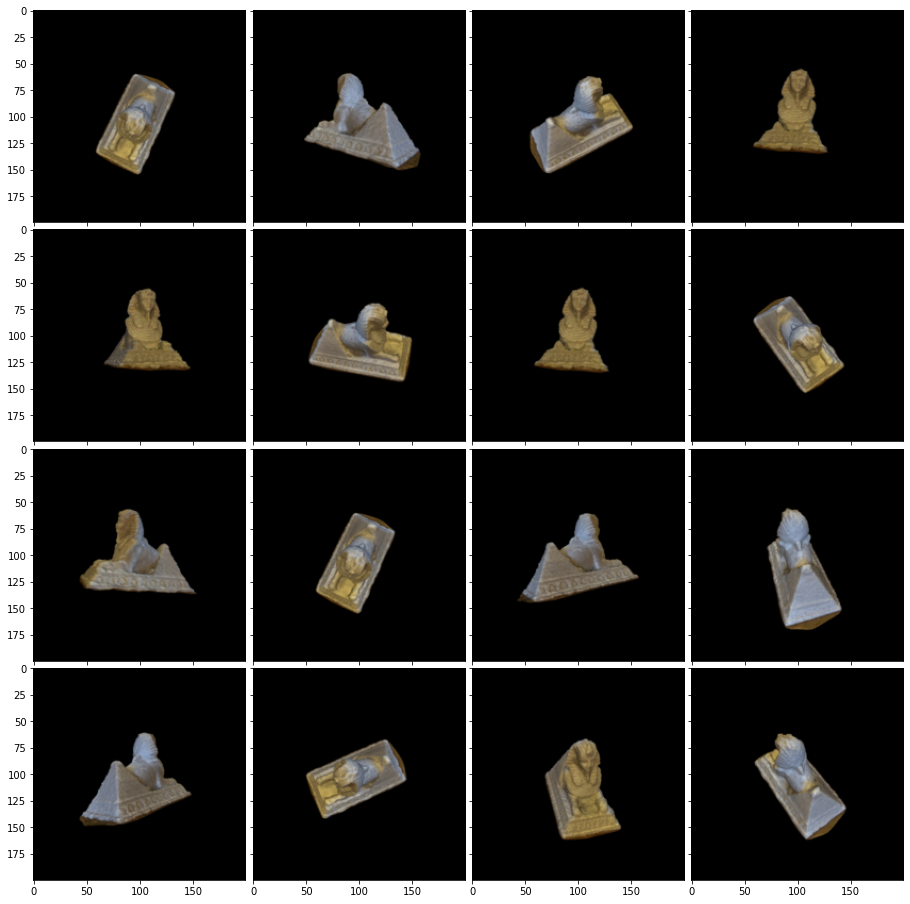

In [5]:
folder_path = 'DataSet/egypt_picture_data'

file_names = os.listdir(folder_path)

images_data = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    img = Image.open(file_path)

    img = img.resize((200, 200))

    img_array = np.array(img)

    img_array = np.array(img) / 255.0

    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        images_data.append(img_array)

images = np.array(images_data)

poses_data = np.load('DataSet/camera_positions.npz')
poses = poses_data['arr1']
focal = 1.0
focal = np.array(focal)
v, f = pcu.load_mesh_vf("DataSet/egypt_model/baked_mesh.obj")

H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[99], poses[99]
images = images[:90,...,:3]
poses = poses[:90]

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from model data")
plt.show()

In [6]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(1e-4)

# Output view and Peak signal-to-noise ratio every 25 iterations
N_samples = 64
N_iters = 10000
log_cosh_loss = []
psnrs = []
ssims = []
timeList = []
iternums = []
i_plot = 500
import time

t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0]) 
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, v, f, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)

        # Calculate loss with Mean Squared Error
        loss = tf.reduce_mean(tf.square(rgb - testimg))



    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    log_cosh_loss.append(loss.numpy())
    if i%i_plot==0:
        time_per_iter = (time.time() - t) / i_plot
        timeList.append(time_per_iter)
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, v, f, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)
        # rgb, depth, acc, consistency, consistency_loss = render_rays(model, v, f, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        # Calculate PSNR
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        # Calculate SSIM
        testimg_float = tf.cast(testimg, tf.float32)
        rgb_float = tf.cast(rgb, tf.float32)
        ssim_value = tf.image.ssim(testimg_float, rgb_float, max_val = 1.0)

        psnrs.append(psnr.numpy())
        ssims.append(ssim_value.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'RGB image, Iteration: {i}')
        egypt_rgb_image = 'egypt_rgb_image'
        if not os.path.exists(egypt_rgb_image):
            os.makedirs(egypt_rgb_image)
        output_path = os.path.join(egypt_rgb_image, f'{i}-rgb_image.png')
        plt.savefig(output_path)
        plt.close()
        
        plt.figure(figsize=(10,4))
        plt.subplot(122)
        plt.plot(iternums, ssims)
        plt.title('SSIM')
        egypt_ssim_image = 'egypt_ssim_image'
        if not os.path.exists(egypt_ssim_image):
            os.makedirs(egypt_ssim_image)
        output_path = os.path.join(egypt_ssim_image, f'{i}-ssim_image.png')
        plt.savefig(output_path)
        plt.close()

        plt.figure(figsize=(10,4))
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        egypt_psnr_image = 'egypt_psnr_image'
        if not os.path.exists(egypt_psnr_image):
            os.makedirs(egypt_psnr_image)
        output_path = os.path.join(egypt_psnr_image, f'{i}-psnr_image.png')
        plt.savefig(output_path)
        plt.close()

# Store PSNR data
iteration_number = list(range(0, 10000, 500))
psnr_file_path = 'egypt_PSNR_Data.txt'

if not os.path.exists(psnr_file_path):
    with open(psnr_file_path, 'w') as file:
        file.write("Iteration Number\tTime per iter\tPSNR\n")

with open(psnr_file_path, 'a') as file:
    for col, val_a, val_b in zip(iteration_number, timeList, psnrs):
        file.write(f"{col}\t{val_a}\t{val_b}\n")
print(f"PSNR data written to {psnr_file_path}")

# Store SSIM data
ssim_file_path = 'egypt_SSIM_data.txt'

if not os.path.exists(ssim_file_path):
    with open(ssim_file_path, 'w') as file:
        file.write("Iteration Number\tTime per iter\tSSIM\n")

with open(ssim_file_path, 'a') as file:
    for col, val_a, val_b in zip(iteration_number, timeList, ssims):
        file.write(f"{col}\t{val_a}\t{val_b}\n")
print(f"SSIM data written to {ssim_file_path}")

print('Done')

2023-08-27 04:01:48.454969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 04:01:49.170023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


0 0.007925586223602295 secs per iter
500 3.3384454951286315 secs per iter
1000 3.300257019519806 secs per iter
1500 3.3325746154785154 secs per iter
2000 3.3515332884788513 secs per iter
2500 3.3441103734970095 secs per iter
3000 3.3622990403175352 secs per iter
3500 3.3643245215415956 secs per iter
4000 3.3420075817108152 secs per iter
4500 3.3467424554824827 secs per iter
5000 3.320276557445526 secs per iter
5500 3.3887391591072085 secs per iter
6000 3.36574489402771 secs per iter
6500 3.3283996028900145 secs per iter
7000 3.330040739059448 secs per iter
7500 3.341368408679962 secs per iter
8000 3.3609443249702453 secs per iter
8500 3.414237205982208 secs per iter
9000 3.3494597969055175 secs per iter
9500 3.3180955443382265 secs per iter
10000 3.3712469301223753 secs per iter
PSNR data written to egypt_PSNR_Data.txt
SSIM data written to egypt_SSIM_data.txt
Done


In [ ]:
Plane model reconstruction

2023-08-27 13:56:28.993974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 13:56:29.653646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


tf.Tensor([100 200 200   3], shape=(4,), dtype=int32)
(100, 200, 200, 3) (100, 4, 4) 1.0


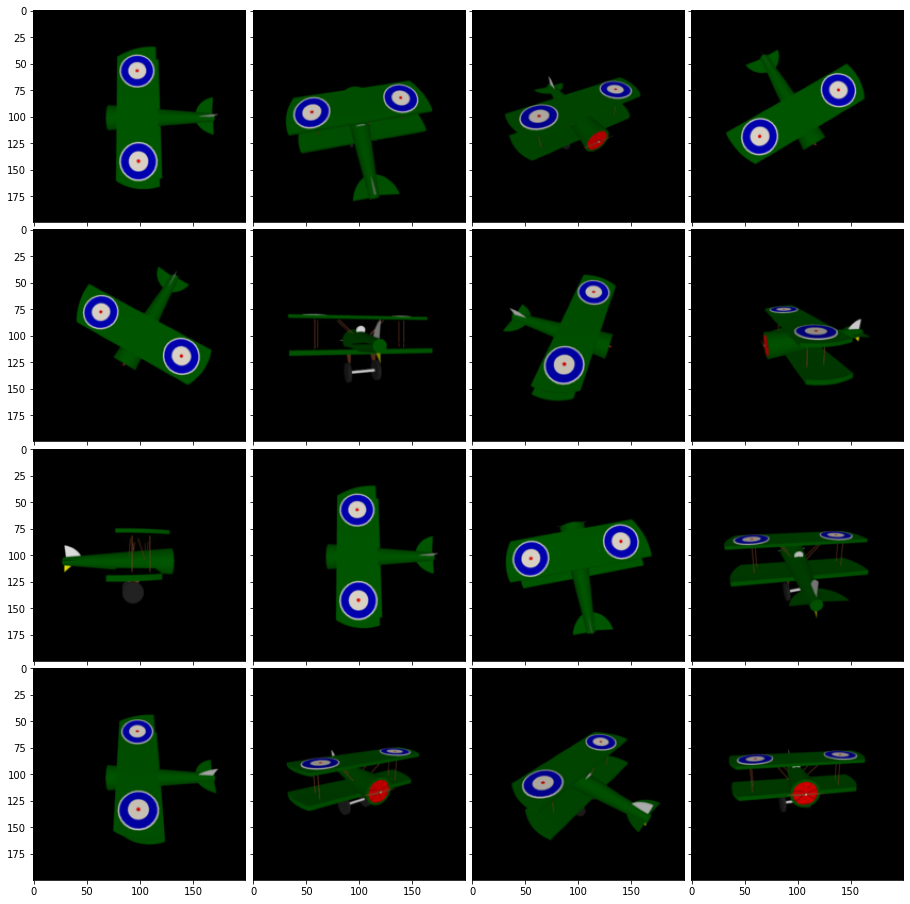

In [5]:
folder_path = 'DataSet/model_picture_data'

file_names = os.listdir(folder_path)

images_data = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)

    img = Image.open(file_path)

    img = img.resize((200,200))

    img_array = np.array(img)

    img_array = np.array(img) / 255.0

    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        images_data.append(img_array)

images = np.array(images_data)
print(tf.shape(images))

poses_data = np.load('DataSet/camera_positions.npz')
poses = poses_data['arr1']
focal = 1.0
focal = np.array(focal)
v, f = pcu.load_mesh_vf("DataSet/models/model_normalized.obj")

H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[99], poses[99]
images = images[:90,...,:3]
poses = poses[:90]

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from model data")
plt.show()

In [6]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(1e-4)

# Output view and Peak signal-to-noise ratio every 25 iterations
N_samples = 64
N_iters = 10000
log_cosh_loss = []
psnrs = []
ssims = []
timeList = []
iternums = []
i_plot = 500
import time

t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0]) 
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, v, f, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)

        # Calculate loss with Mean Squared Error
        loss = tf.reduce_mean(tf.square(rgb - testimg))



    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    log_cosh_loss.append(loss.numpy())
    if i%i_plot==0:
        time_per_iter = (time.time() - t) / i_plot
        timeList.append(time_per_iter)
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, v, f, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)
        # rgb, depth, acc, consistency, consistency_loss = render_rays(model, v, f, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        # Calculate PSNR
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        # Calculate SSIM
        testimg_float = tf.cast(testimg, tf.float32)
        rgb_float = tf.cast(rgb, tf.float32)
        ssim_value = tf.image.ssim(testimg_float, rgb_float, max_val = 1.0)

        psnrs.append(psnr.numpy())
        ssims.append(ssim_value.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'RGB image, Iteration: {i}')
        plane_rgb_image = 'plane_rgb_image'
        if not os.path.exists(plane_rgb_image):
            os.makedirs(plane_rgb_image)
        output_path = os.path.join(plane_rgb_image, f'{i}-rgb_image.png')
        plt.savefig(output_path)
        plt.close()
        
        plt.figure(figsize=(10,4))
        plt.subplot(122)
        plt.plot(iternums, ssims)
        plt.title('SSIM')
        plane_ssim_image = 'plane_ssim_image'
        if not os.path.exists(plane_ssim_image):
            os.makedirs(plane_ssim_image)
        output_path = os.path.join(plane_ssim_image, f'{i}-ssim_image.png')
        plt.savefig(output_path)
        plt.close()

        plt.figure(figsize=(10,4))
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plane_psnr_image = 'plane_psnr_image'
        if not os.path.exists(plane_psnr_image):
            os.makedirs(plane_psnr_image)
        output_path = os.path.join(plane_psnr_image, f'{i}-psnr_image.png')
        plt.savefig(output_path)
        plt.close()

# Store PSNR data
iteration_number = list(range(0, 10000, 500))
psnr_file_path = 'plane_PSNR_Data.txt'

if not os.path.exists(psnr_file_path):
    with open(psnr_file_path, 'w') as file:
        file.write("Iteration Number\tTime per iter\tPSNR\n")

with open(psnr_file_path, 'a') as file:
    for col, val_a, val_b in zip(iteration_number, timeList, psnrs):
        file.write(f"{col}\t{val_a}\t{val_b}\n")
print(f"PSNR data written to {psnr_file_path}")

# Store SSIM data
ssim_file_path = 'plane_SSIM_data.txt'

if not os.path.exists(ssim_file_path):
    with open(ssim_file_path, 'w') as file:
        file.write("Iteration Number\tTime per iter\tSSIM\n")

with open(ssim_file_path, 'a') as file:
    for col, val_a, val_b in zip(iteration_number, timeList, ssims):
        file.write(f"{col}\t{val_a}\t{val_b}\n")
print(f"SSIM data written to {ssim_file_path}")


print('Done')

0 0.007120259761810303 secs per iter
500 3.2532812232971193 secs per iter
1000 3.2647105894088746 secs per iter
1500 3.270575953006744 secs per iter
2000 3.2892053327560427 secs per iter
2500 3.3054169430732725 secs per iter
3000 3.3135382351875307 secs per iter
3500 3.31614391374588 secs per iter
4000 3.2777263541221617 secs per iter
4500 3.3088767404556276 secs per iter
5000 3.3866367359161376 secs per iter
5500 3.366347515106201 secs per iter
6000 3.302763774394989 secs per iter
6500 3.2713599801063538 secs per iter
7000 3.3436303453445433 secs per iter
7500 3.374350615501404 secs per iter
8000 3.3574502992630006 secs per iter
8500 3.320933826446533 secs per iter
9000 3.3191932106018065 secs per iter
9500 3.3560380687713622 secs per iter
10000 3.3806013879776002 secs per iter
PSNR data written to plane_PSNR_Data.txt
SSIM data written to plane_SSIM_data.txt
Done
